In [1]:
from scipy.io import arff
import numpy as np
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer
from collections import defaultdict
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pickle
from sklearn.model_selection import KFold
from sklearn.base import clone

In [2]:
# utility functions
def get_data(data, relevant_params):
    task_ids = data['task_id'].unique()
    data = data.loc[data['svc__kernel'] == b'rbf']
    data = data[relevant_params + ['task_id'] + ['predictive_accuracy']]
    data_dict = defaultdict()
    for task_id in task_ids:
        X_task = data.loc[data['task_id'] == task_id]
        y_task = np.array(X_task['predictive_accuracy'], dtype=np.float)
        X_task.drop(['predictive_accuracy', 'task_id'], 1, inplace=True)
        categorical_names = X_task.select_dtypes(include=['object']).columns
        categorical_ids = [X_task.columns.get_loc(colname) for colname in categorical_names]
        data_dict[task_id] = (X_task.as_matrix(), y_task, categorical_ids)
    return data_dict

def precatn(task_id, model, X, y, kfolds=5, topn=5):
    kf = KFold(n_splits=kfolds, random_state=42, shuffle=True)
    splits = kf.split(X)
    scores = []
    for train_idx, test_idx in splits:
        train_x, train_y = X[train_idx], y[train_idx]
        test_x, test_y = X[test_idx], y[test_idx]
        new_model = clone(model)
        new_model.fit(train_x, train_y)
        y_hat = new_model.predict(test_x)
        y_hat_ranks = rankdata(y_hat, method='average')
        test_y_ranks = rankdata(test_y, method='average')
        y_hat_maxargs = y_hat_ranks.argsort()
        test_y_maxargs = test_y_ranks.argsort()
        cnt = 0
        for entry in y_hat_maxargs[:topn]:
            if entry in test_y_maxargs[:topn]:
                cnt += 1
        scores.append(cnt / topn)
    mean_score = np.mean(scores)
    print('Task %d; Precision at %d Score: %0.4f' %(task_id, topn, mean_score))
    return mean_score

def custom_scorer(y, y_hat):
    return pearsonr(y, y_hat)[0]

def pearsonscore(task_id, model, X, y, kfolds=5):
    # y_hat = cross_val_predict(clf, X, y, cv=kfolds)
    # score = pearsonr(y, y_hat)[0]
    scores = cross_val_score(model, X, y, cv=kfolds, scoring=make_scorer(custom_scorer))
    score = scores.mean()
    print('Task %d; Pearson Spearman Correlation: %0.4f (+/- %0.4f)' %(task_id, score, scores.std() * 2))
    return score

def get_noise(task_id, model, X, y, kfolds=5):
    kf = KFold(n_splits=kfolds, random_state=42, shuffle=True)
    splits = kf.split(X)
    y_hat_all = []
    for train_idx, test_idx in splits:
        train_x, train_y = X[train_idx], y[train_idx]
        test_x, test_y = X[test_idx], y[test_idx]
        new_model = clone(model)
        new_model.fit(train_x, train_y)
        y_hat = new_model.predict(test_x)
        y_hat_all.append(y_hat)
    scores = []
    for y_hat, i in enumerate(y_hat_all):
        for j in range(i + 1, topn):
            scores.append(pearsonr(y_hat, y_hat_all[j]))
    return np.mean(scores)

In [3]:
filename = './data/svc.arff'
relevant_params = ['svc__C', 'svc__gamma']
data, meta = arff.loadarff(filename)
df = pd.DataFrame(data)
data_dict = get_data(df, relevant_params)

/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [4]:
class surrogate:

    def __init__(self, ntrees=16):
        self.models = {}
        self.ntrees = ntrees

    def train_model_rs(self, X, y, categoricals, task_id):
        if task_id in self.models:
            return self.models[task_id]
        param_dist = {'max_depth': np.arange(3, 11),
              'max_features': [1, 2],
              'n_estimators' : [100],
              'min_samples_split': np.arange(2, 11)}
        clf = Pipeline(
            steps=[('encoder', sklearn.preprocessing.OneHotEncoder(
                categorical_features=list(categoricals), handle_unknown='ignore')),
                    ('random search', RandomizedSearchCV(RandomForestRegressor(n_estimators=self.ntrees), 
                                                         param_distributions=param_dist,
                                                         n_iter=20, cv=5))])
        clf.fit(X, y)
        self.models[task_id] = clf
        return clf
    
    def train_model(self, X, y, categoricals, task_id):
        if task_id in self.models:
            return self.models[task_id]
        clf = Pipeline(
            steps=[('encoder', sklearn.preprocessing.OneHotEncoder(
                categorical_features=list(categoricals), handle_unknown='ignore')),
                    ('classifier', RandomForestRegressor(n_estimators=self.ntrees))])
        clf.fit(X, y)
        self.models[task_id] = clf
        return clf

    def train_surrogate(self, data_dict):
        task_ids = list(data_dict.keys())
        scores = []
        for task_id in task_ids:
            X, y, categoricals = data_dict[task_id]
            clf = self.train_model_rs(X, y, categoricals, task_id)
            precatn_score = precatn(task_id, clf.named_steps['random search'].best_estimator_, X, y, topn=100)
            pearson_score = pearsonscore(task_id, clf.named_steps['random search'].best_estimator_, X, y)
            scores.append(np.array([precatn_score, pearson_score]))
        return np.array(scores)

In [5]:
np.mean(np.sum([len(data_dict[task_id]) for task_id in list(data_dict.keys())]))

300.0

In [ ]:
s = surrogate()
surrogate_scores = s.train_surrogate(data_dict)

In [5]:
surrogates = pickle.load(open('/Users/prernakashyap/Documents/autoML research/models/sm2.pkl', 'rb'))

/Users/prernakashyap/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/prernakashyap/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/prernakashyap/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/prernakashyap/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.19.0 when

In [12]:
surrogate_scores = []
task_ids = list(data_dict.keys())
for task_id in task_ids:
    X, y, categoricals = data_dict[task_id]
    clf = surrogates.models[task_id].named_steps['random search'].best_estimator_
    precatn_score = precatn(task_id, clf, X, y, topn=100)
    pearson_score = pearsonscore(task_id, clf, X, y)
    surrogate_scores.append(np.array([precatn_score, pearson_score]))
surrogate_scores = np.array(surrogate_scores)

Task 3; Precision at 100 Score: 0.9820
Task 3; Pearson Spearman Correlation: 0.9865 (+/- 0.0086)
Task 6; Precision at 100 Score: 0.9840
Task 6; Pearson Spearman Correlation: 0.9927 (+/- 0.0029)
Task 11; Precision at 100 Score: 0.9800
Task 11; Pearson Spearman Correlation: 0.9631 (+/- 0.0297)
Task 12; Precision at 100 Score: 0.9820
Task 12; Pearson Spearman Correlation: 0.9987 (+/- 0.0015)
Task 14; Precision at 100 Score: 0.9580
Task 14; Pearson Spearman Correlation: 0.9962 (+/- 0.0067)
Task 15; Precision at 100 Score: 0.8880
Task 15; Pearson Spearman Correlation: 0.9661 (+/- 0.0306)
Task 16; Precision at 100 Score: 0.9740
Task 16; Pearson Spearman Correlation: 0.9963 (+/- 0.0031)
Task 18; Precision at 100 Score: 0.9780
Task 18; Pearson Spearman Correlation: 0.9895 (+/- 0.0111)
Task 20; Precision at 100 Score: 0.9620
Task 20; Pearson Spearman Correlation: 0.9980 (+/- 0.0022)
Task 21; Precision at 100 Score: 0.9800
Task 21; Pearson Spearman Correlation: 0.9915 (+/- 0.0043)
Task 22; Preci

In [10]:
class simplified_surrogate:

    def __init__(self):
        self.models = {}

    def train_model(self, data_dict):
        scores = []
        for task_id in data_dict:
            X, y, _ = data_dict[task_id]
            poly = PolynomialFeatures(2)
            X = poly.fit_transform(X)
            X = np.delete(X, 0, 1)
            model = LinearRegression()
            model.fit(X, y)
            self.models[task_id] = model
            precatn_score = precatn(task_id, model, X, y, topn=100)
            pearson_score = pearsonscore(task_id, model, X, y)
            scores.append(np.array([precatn_score, pearson_score]))
        return np.array(scores)


In [11]:
s_ = simplified_surrogate()
simplified_surrogate_scores = s_.train_model(data_dict)

Task 3; Precision at 100 Score: 0.8440
Task 3; Pearson Spearman Correlation: 0.6233 (+/- 0.0700)
Task 6; Precision at 100 Score: 0.8040
Task 6; Pearson Spearman Correlation: 0.4578 (+/- 0.0803)
Task 11; Precision at 100 Score: 0.8500
Task 11; Pearson Spearman Correlation: 0.3715 (+/- 0.0800)
Task 12; Precision at 100 Score: 0.8000
Task 12; Pearson Spearman Correlation: 0.7769 (+/- 0.0531)
Task 14; Precision at 100 Score: 0.8840
Task 14; Pearson Spearman Correlation: 0.7832 (+/- 0.1274)
Task 15; Precision at 100 Score: 0.7000
Task 15; Pearson Spearman Correlation: 0.2724 (+/- 0.2563)
Task 16; Precision at 100 Score: 0.8200
Task 16; Pearson Spearman Correlation: 0.7921 (+/- 0.0599)
Task 18; Precision at 100 Score: 0.7640
Task 18; Pearson Spearman Correlation: 0.2892 (+/- 0.1161)
Task 20; Precision at 100 Score: 0.8800
Task 20; Pearson Spearman Correlation: 0.5511 (+/- 0.0667)
Task 21; Precision at 100 Score: 0.8340
Task 21; Pearson Spearman Correlation: 0.5419 (+/- 0.0810)
Task 22; Preci

Task 14968; Precision at 100 Score: 0.8320
Task 14968; Pearson Spearman Correlation: 0.5714 (+/- 0.0244)
Task 14969; Precision at 100 Score: 0.7420
Task 14969; Pearson Spearman Correlation: 0.2913 (+/- 0.0394)
Task 14970; Precision at 100 Score: 0.9120
Task 14970; Pearson Spearman Correlation: 0.6471 (+/- 0.0748)
Task 34536; Precision at 100 Score: 0.8140
Task 34536; Pearson Spearman Correlation: 0.4070 (+/- 0.0957)
Task 34537; Precision at 100 Score: 0.7860
Task 34537; Pearson Spearman Correlation: 0.3721 (+/- 0.0706)
Task 34538; Precision at 100 Score: 0.8680
Task 34538; Pearson Spearman Correlation: 0.7680 (+/- 0.0786)
Task 34539; Precision at 100 Score: 0.6460
Task 34539; Pearson Spearman Correlation: 0.2004 (+/- 0.1390)
Task 125920; Precision at 100 Score: 0.7340
Task 125920; Pearson Spearman Correlation: 0.4132 (+/- 0.0616)
Task 125921; Precision at 100 Score: 0.6680
Task 125921; Pearson Spearman Correlation: 0.2866 (+/- 0.0859)
Task 125922; Precision at 100 Score: 0.8840
Task 12

# Creating new dataset

In [12]:
meta_filename = './data/metafeatures.arff'
meta, _ = arff.loadarff(meta_filename)
df_meta = pd.DataFrame(meta)

In [15]:
model_params = defaultdict(list)
task_ids = list(data_dict.keys())
task_ids.remove(34536.0)
modified_data_dict = defaultdict(list)
for i, task_id in enumerate(task_ids):
    params = s_.models[task_id].coef_
    model_params['a'].append(params[0]) #C
    model_params['b'].append(params[1]) #gamma
    model_params['c'].append(params[2]) #C^2
    model_params['d'].append(params[3]) #C.gamma
    model_params['e'].append(params[4]) #gamma^2
    model_params['f'].append(s_.models[task_id].intercept_) #intercept
    X_task, y_task, _ = data_dict[task_id]
    X_temp = np.empty([0,22])
    for j in range(len(X_task)):
        modified_data_dict['task_id'].append(task_id)
        modified_data_dict['C'].append(X_task[j,0])
        modified_data_dict['gamma'].append(X_task[j,1])
        modified_data_dict['y'].append(y_task[j])
        modified_data_dict['a'].append(model_params['a'][-1])
        modified_data_dict['b'].append(model_params['b'][-1])
        modified_data_dict['c'].append(model_params['c'][-1])
        modified_data_dict['d'].append(model_params['d'][-1])
        modified_data_dict['e'].append(model_params['e'][-1])
        modified_data_dict['f'].append(model_params['f'][-1])
        for cidx, column in enumerate(df_meta.columns):
            modified_data_dict[column].append(df_meta.iloc[i].as_matrix()[cidx])

/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [18]:
new_data = pd.DataFrame(modified_data_dict)

In [24]:
import arff # pip's not scipy's
arff.dump('./data/new_data.arff'
      , new_data.values
      , relation='c, gamma, metafeatures and predictive accuracies for all tasks'
      , names=new_data.columns)

# Boxplot for precision at 100 measure

In [15]:
def draw_plot(data, offset,edge_color, fill_color):
    pos = np.arange(1) + offset 
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

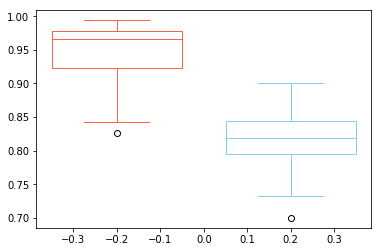

In [16]:
fig, ax = plt.subplots()
draw_plot(surrogate_scores[:,0], -0.2, 'tomato', 'white')
draw_plot(simplified_surrogate_scores[:,0], +0.2, 'skyblue', 'white')
plt.show()
plt.close()

# Boxplot for pearson correlation measure

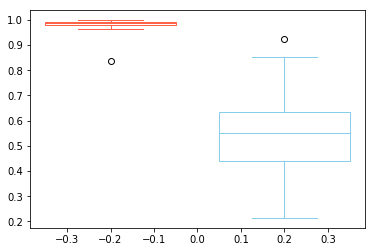

In [17]:
fig, ax = plt.subplots()
draw_plot(surrogate_scores[:,1], -0.2, 'tomato', 'white')
draw_plot(simplified_surrogate_scores[:,1], +0.2, 'skyblue', 'white')
plt.show()
plt.close()